In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import seaborn as sns
import librosa
import librosa.display
from IPython import display
from sklearn.utils.class_weight import compute_class_weight
from sklearn import metrics

In [ ]:
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

In [ ]:
import warnings
warnings.filterwarnings('ignore')

## Explore dataset

Load csv file with information about the training data

In [ ]:
birdcall_meta = pd.read_csv('/kaggle/input/birdsong-recognition/train.csv')

Let's see how many training files we have and how many columns with information about the audio files

In [ ]:
print('Dataset has %d rows and %d columns' % birdcall_meta.shape, end="")

In [ ]:
pd.set_option('display.max_columns', 35)
birdcall_meta.sample(5, random_state = 1)

### Explore the distributions of the number of files and file duration

We want to see how many distinct bird species there are in the data set and the distribution of observations and audio clip duration over species.

In [ ]:
print('There are %d unique bird species in the dataset' % birdcall_meta['ebird_code'].nunique(), end="")

From the bar chart below we can see that most species have between 90 and 100 observations

In [ ]:
species_count = birdcall_meta.groupby(['species']).size().reset_index()
species_count['Number of audio files interval'] = pd.cut(species_count[0], np.arange(0,110,10))
species_count_bins = species_count.groupby(['Number of audio files interval']).size()
species_count_bins.plot(kind="barh", title="Count of species by number of audio files", color='green');

And below we see that most species have between 5 and 120 minutes of recordings

In [ ]:
species_duration = birdcall_meta.groupby(['species']).sum()['duration'].reset_index()
species_duration['duration_mins'] = np.round(species_duration['duration']/60)
species_duration['Duration interval'] =  pd.cut(species_duration['duration_mins'], 10)
species_duration_bins = species_duration.groupby(['Duration interval']).size()
species_duration_bins.plot(kind="barh", title="Count of species by total duration of recordings", color='yellow');

Because we will split the audio files in chunks of 3 seconds for example, we want to see which are the species with longest and shortest total duration of recorded audio files

In [ ]:
species_duration_top = (
    species_duration
      .sort_values('duration', ascending=False)
      .head(10)[['species', 'duration_mins']]
      .set_index('species')
)
ax = species_duration_top.plot(kind="barh", title="Top 10 species by total duration of recordings", color='darkblue');
ax.invert_yaxis()

In [ ]:
species_duration_bottom = (
    species_duration
      .sort_values('duration', ascending=True)
      .head(10)[['species', 'duration_mins']]
      .set_index('species')
)
ax = species_duration_bottom.plot(kind="barh", title="Bottom 10 species by total duration of recordings", color='lightblue');
ax.invert_yaxis()

### Look at pitch, speed, time of day, month of year, elevation and country

Below I plot a few more interesting features: pitch, speed, time of day, month of year, elevation and country

In [ ]:
pitch_count =  birdcall_meta.groupby(['pitch']).size()
pitch_count.name = 'Pitch distribution'
pitch_count.plot.pie(y='Pitch distribution', figsize=(6, 6));

In [ ]:
speed_count =  birdcall_meta.groupby(['speed']).size()
speed_count.name = 'Speed distribution'
speed_count.plot.pie(y='Speed distribution', figsize=(6, 6));

I define a function to extract the time of day from various formats in the dataset

In [ ]:
def extract_hour_of_day(time):
    time = time.lower()
    hour = time[:time.find(':')]
    if hour.isnumeric():
        hour = int(hour)
    else:
        hour = np.nan
        
    if ('pm' in time) & (hour !=12):
        hour = hour+12    
    if ('am' in time) & (hour ==12):
        hour = 0    
    return hour

In [ ]:
birdcall_meta['hour_of_day'] = list(map(extract_hour_of_day, birdcall_meta['time']))

Extract month of year from date string

In [ ]:
birdcall_meta['month_of_year'] = birdcall_meta['date'].str[5:7]

Pivot time and month to create a dataframe for a nice heatmap

In [ ]:
time_count = pd.pivot_table(birdcall_meta, values='rating', index=['hour_of_day'],
                    columns=['month_of_year'], aggfunc='count')
del time_count['00']

It looks like most data was collected in the morning around May and June

In [ ]:
sns.heatmap(time_count);

I create a function to extract the elevation values from various formats

In [ ]:
def extract_elevation(elevation):
    elevation = elevation.replace('m', '')
    elevation = elevation.replace('~', '')
    elevation = elevation.replace(',', '').strip()
    if elevation.isnumeric():
        elevation = float(elevation)
    else:
        elevation = np.nan
    return elevation

In [ ]:
birdcall_meta['elevation_clean'] = list(map(extract_elevation, birdcall_meta['elevation']))

In [ ]:
sns.distplot(birdcall_meta['elevation_clean'], kde=False);

In [ ]:
country_count = birdcall_meta.groupby(['country']).size().sort_values(ascending=False).head(10)
country_count.name = 'count'
ax = country_count.plot(kind="barh", title="Count of recordings by country", color='darkgreen');
ax.invert_yaxis()

### Melspectrogram

Load an example file and plot melspectrogram

In [ ]:
ex_file = ('/kaggle/input/birdsong-recognition/train_audio'+ '/' + 
           birdcall_meta['ebird_code']+ '/' + 
           birdcall_meta['filename']).iloc[4423] #4423
x, sr = librosa.load(ex_file)

In [ ]:
display.Audio(data=x, rate=sr)

In [ ]:
plt.figure(figsize=(14, 5))
librosa.display.waveplot(x, sr=sr);

The Fourier transform converts an audio signal from a time and amplitude domain to a frequency and amplitude domain.

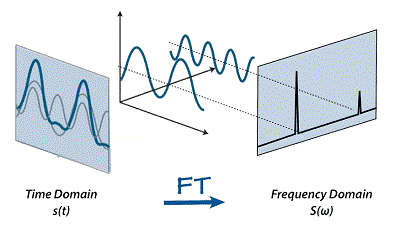

To retain the time information we can use apply the Fourier transform over widows of the audio signal. The result can be visualized in a spectrogram, in which one dimension represents time, the other frequency and the colors represent the amplitude.

Further the melspectrogram shows the frequency in the mel scale (a non-linear transformation of the Hz scale).

In [ ]:
plt.figure(figsize=(14, 5))
s = librosa.feature.melspectrogram(x, sr=sr, n_fft=1028, hop_length=512, n_mels=128)
s_db = librosa.power_to_db(s, ref=np.max)
librosa.display.specshow(s_db, sr=sr);

### Remove silence

I am following the procedure in this paper: http://ceur-ws.org/Vol-1609/16090547.pdf

In [ ]:
norm_s = (s-s.min())/(s.max()-s.min())

In [ ]:
from scipy.ndimage.morphology import binary_erosion,binary_dilation

For each image keep the pixels which are 3 times higher that column and row median

In [ ]:
column_medians = np.median(norm_s, axis=0)
row_medians = np.median(norm_s, axis=1)

In [ ]:
filtered_spectrogram = np.greater(norm_s, column_medians*3)&np.greater(norm_s.T, row_medians*3).T*1

In [ ]:
librosa.display.specshow(filtered_spectrogram);

Apply binary erosion

In [ ]:
eroded_spectrogram = binary_erosion(filtered_spectrogram)

In [ ]:
librosa.display.specshow(eroded_spectrogram);

Apply dilation

In [ ]:
dilated_idx = binary_dilation(eroded_spectrogram.sum(axis=0)>0,  iterations=3)

In [ ]:
plt.plot(dilated_idx,'ro')

In [ ]:
dilated_idx.mean()

In [ ]:
x.shape[0]

In [ ]:
(np.round(np.interp(np.arange(x.shape[0]), np.arange(dilated_idx.shape[0])*x.shape[0]/dilated_idx.shape[0], dilated_idx)))

In [ ]:
plt.plot(np.round(np.interp(np.arange(x.shape[0]), np.arange(dilated_idx.shape[0])*x.shape[0]/dilated_idx.shape[0], dilated_idx)),'ro')

In [ ]:
plt.figure(figsize=(14, 5))
s = librosa.feature.melspectrogram(x, sr=sr, n_fft=1028, hop_length=512, n_mels=128)
s_db = librosa.power_to_db(s[:,dilated_idx], ref=np.max)
librosa.display.specshow(s_db, sr=sr);

## Classification based on melspectrogram

To showcase the general ideas in this notebook I only pick a few species out to the total 264 species.

In [ ]:
np.random.seed(0)
sample_classes = 3
sample_species = list(np.random.choice(birdcall_meta['ebird_code'].unique(), sample_classes, replace=False))

In [ ]:
birdcall_meta_samp = birdcall_meta[(birdcall_meta['ebird_code'].isin(sample_species))]

In [ ]:
species_duration_samp =  birdcall_meta_samp.groupby(['species']).sum()['duration']
species_duration_samp.plot.pie(y='Duration distribution', figsize=(6, 6));

In [ ]:
birdcall_meta_samp['path'] = '/kaggle/input/birdsong-recognition/train_audio'+ '/' +  \
                            birdcall_meta_samp['ebird_code'] + '/' + \
                            birdcall_meta_samp['filename']

In [ ]:
birdcall_meta_samp['chunks'] = np.floor(birdcall_meta_samp['duration']/3).astype(int)

In [ ]:
birdcall_meta_samp = birdcall_meta_samp[birdcall_meta_samp['chunks']>0]
birdcall_meta_samp = birdcall_meta_samp[birdcall_meta_samp['duration']<120]

In [ ]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
birdcall_meta_samp['class_code'] = le.fit_transform(birdcall_meta_samp['ebird_code'])

In [ ]:
from sklearn.model_selection import train_test_split
birdcall_train, birdcall_test = train_test_split(birdcall_meta_samp, test_size=0.2, random_state=0, stratify=birdcall_meta_samp[['ebird_code']])

In [ ]:
birdcall_train[['path','chunks','duration','class_code']]

In [ ]:
sample_size = birdcall_train.shape[0]

In [ ]:
sample_size

Split audio files in 3s pieces

In [ ]:
sec_split = 3

In [ ]:
classes_size = birdcall_train['ebird_code'].nunique()

In [ ]:
classes_size

In [ ]:
obs_train = birdcall_train['chunks'].sum()

In [ ]:
obs_train

In [ ]:
X_train = np.zeros((obs_train, 128, 130))
Y_train = np.zeros((obs_train, classes_size))

In [ ]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
scaler = StandardScaler()
#minmaxscaler = MinMaxScaler()

In [ ]:
i=0
for r in birdcall_train[['path','class_code']].iterrows():
    x, sr = librosa.load(r[1]['path'])
    S = librosa.feature.melspectrogram(x, sr=sr, n_fft=1028, hop_length=512, n_mels=128)
    norm_S = (S-S.min())/(S.max()-S.min())
    column_medians = np.median(norm_S, axis=0)
    row_medians = np.median(norm_S, axis=1)
    eroded_spectrogram = binary_erosion(np.greater(norm_S, column_medians*3)&np.greater(norm_S.T, row_medians*3).T*1)
    dilated_idx = binary_dilation(eroded_spectrogram.sum(axis=0)>0,  iterations=3)
    x =x[np.round(np.interp(np.arange(x.shape[0]),
                            np.arange(dilated_idx.shape[0])*x.shape[0]/dilated_idx.shape[0],
                            dilated_idx)).astype(bool)]
    x=x[:int(np.floor(x.shape[0]/sr/sec_split)*sec_split*sr)]
    if x.shape[0]>0:
        for n in np.array_split(x, np.floor(x.shape[0]/sr/sec_split)):        
            print('Loading train data [%.2f%%]\r'% np.round(i/obs_train*100, 2), end="")
            S = librosa.feature.melspectrogram(n, sr=sr, n_fft=1028, hop_length=512, n_mels=128)
            S_DB_sc = scaler.fit_transform(librosa.power_to_db(S))
    #         S_DB_mm = minmaxscaler.fit_transform(S_DB_sc)
            X_train[i, :, :] = S_DB_sc
            Y_train[i, r[1]['class_code']] = 1
            i += 1

In [ ]:
i

In [ ]:
X_train = X_train[:i, :, :]
Y_train = Y_train[:i, :]

In [ ]:
obs_test = birdcall_test['chunks'].sum()

In [ ]:
obs_test

In [ ]:
X_test = np.zeros((obs_test, 128, 130))
Y_test = np.zeros((obs_test, classes_size))

In [ ]:
j=0
for r in birdcall_test[['path','class_code']].iterrows():
    x, sr = librosa.load(r[1]['path'])
    S = librosa.feature.melspectrogram(x, sr=sr, n_fft=1028, hop_length=512, n_mels=128)
    norm_S = (S-S.min())/(S.max()-S.min())
    column_medians = np.median(norm_S, axis=0)
    row_medians = np.median(norm_S, axis=1)
    eroded_spectrogram = binary_erosion(np.greater(norm_S, column_medians*3)&np.greater(norm_S.T, row_medians*3).T*1)
    dilated_idx = binary_dilation(eroded_spectrogram.sum(axis=0)>0,  iterations=3)
    x =x[np.round(np.interp(np.arange(x.shape[0]),
                            np.arange(dilated_idx.shape[0])*x.shape[0]/dilated_idx.shape[0],
                            dilated_idx)).astype(bool)]
    x=x[:int(np.floor(x.shape[0]/sr/sec_split)*sec_split*sr)]
    if x.shape[0]>0:
        for n in np.array_split(x, np.floor(x.shape[0]/sr/sec_split)):        
            print('Loading test data [%.2f%%]\r'% np.round(j/obs_test*100, 2), end="")
            S = librosa.feature.melspectrogram(n, sr=sr, n_fft=1028, hop_length=512, n_mels=128)
            S_DB_sc = scaler.fit_transform(librosa.power_to_db(S))
    #         S_DB_mm = minmaxscaler.fit_transform(S_DB_sc)
            X_test[j, :, :] = S_DB_sc
            Y_test[j, r[1]['class_code']] = 1
            j += 1

In [ ]:
j

In [ ]:
X_test = X_test[:j, :, :]
Y_test = Y_test[:j, :]

In [ ]:
X_train = X_train.reshape(X_train.shape[0], 128, 130, 1)
X_test = X_test.reshape(X_test.shape[0], 128, 130, 1)

### Train model

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout
from keras import backend as K

In [ ]:
K.clear_session()
model = Sequential()
model.add(Conv2D(16, (4,4), strides=(1, 1), input_shape = (128, 130, 1), padding='same', activation = 'relu'))

model.add(MaxPool2D((4,4)))
model.add(Flatten())

model.add(Dense(32))

model.add(Dense(classes_size, activation = 'softmax'))
model.summary()

In [ ]:
class_weights = compute_class_weight(class_weight='balanced',
                                     classes=np.arange(classes_size),
                                     y=np.argmax(Y_train, axis=1))

In [ ]:
class_weights_dict = {}
for c in np.arange(classes_size):
    class_weights_dict[c] = class_weights[c]

In [ ]:
model.compile('Adam', loss = 'categorical_crossentropy',
              metrics = ['categorical_crossentropy'])
model.fit(x = X_train, y = Y_train, 
          batch_size = 64, 
          epochs = 20, 
          validation_split=0.2,
          class_weight=class_weights_dict)

In [ ]:
Y_pred_test = model.predict_classes(X_test)

In [ ]:
print(metrics.confusion_matrix(np.argmax(Y_test, axis=1), Y_pred_test))

In [ ]:
print(metrics.classification_report(np.argmax(Y_test, axis=1), Y_pred_test, digits=3))

The model is performing ok on a few classes with a simple CNN and data pre-processing. Extending to more classes will probably involve using a more sophisticated CNN and more data manipulation like superimposing noise or multiple birds calls.